[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1iQH3RvK76elgCiJrnKAnNftyk41pJPFy)

# Прогноз цены биткойнa на момент закрытия дневных торгов

## 1. Постановка задачи

### Об исследовании:

- **Объектами исследования:**
    - является Значения биткойнов в долларах США с 01.01.2017 года по 15.11.2019 года.


- **Предметом исследования:**
    - является набор данных "Bitcoin Historical USD Price".


- **Целью работы:**
    - является пример работы с временным рядом и построение модели нейронной сети для его прогноза.

### Сферы применения и актуальность работы

- Финансовый сектор
- Показания датчиков
- Объемы продаж/производства
- Телеметрия it-систем
- и т.д.

### В работе будут рассмотрены следующие задачи

  - Исследование данных;
  - Построение временного ряд;
  - Построение графика Автокорреляции;
  - Создание набора данных для обучения;
  - Создание нейронной сети;
  - Разделение данных;
  - Масштабирование данных;
  - Обучение и проверка модели;
  - Прогнозирование на тестовом наборе данных;
  - Оценка качества модели на тестовой выборке;
  - Построение графика прогнозa.

### Целевые метрики

- $MSE_{(mean\ squared\ error)}$
  - $MSE(y,\hat{y})=\frac{1}{n_{samples}}\sum_{i=0}^{n_{samples}-1}(y_{i}-\hat{y}_{i})^2$
- $R^2_{(coefficient\ of\ determination)}$
  - $R^2(y, \hat{y}) = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2},\ где\  \bar{y} = \frac{1}{n} \sum_{i=1}^{n} y_i\ и \ \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 = \sum_{i=1}^{n} \epsilon_i^2$

## 2. Анализ

#### Подключаем библиотеки

In [0]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings # Убираем отображения сообщений "Предупреждений"
warnings.simplefilter('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # Добавим более четкое отображение графиков

#### Загружаем набор данных

In [0]:
def download_file():
  pwd = !pwd
  !wget 'https://www.dropbox.com/s/h1ey1w0i4zw4tr0/bitcoin-usd-stock-prices.zip' # Скачиваем файл

  with zipfile.ZipFile(pwd[0] + '/bitcoin-usd-stock-prices.zip') as extract_zip: 
    extract_zip.extractall(pwd[0])
    extract_zip.close() # Разархивируем zip архив
  
  find = !find * -iname '*.zip' -print -or -iname '*.csv' -print -or -iname 'sample_data' -prune
  print(pwd) # Выводим текущую директорию
  print(find) # Выводим файлы ['*.zip', '*.csv'] в текущей директории

In [0]:
download_file()

--2020-03-08 09:30:32--  https://www.dropbox.com/s/h1ey1w0i4zw4tr0/bitcoin-usd-stock-prices.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/h1ey1w0i4zw4tr0/bitcoin-usd-stock-prices.zip [following]
--2020-03-08 09:30:32--  https://www.dropbox.com/s/raw/h1ey1w0i4zw4tr0/bitcoin-usd-stock-prices.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9b4abf210d96867a89eaf9040f.dl.dropboxusercontent.com/cd/0/inline/Azh_nSw3_Bm70w8hJvLv03SYOWzzos4uZQWhWJplaVmnIpjhcluKKG1qGpJ3qScQ-0F6IPYcj5aBzpprz3JQjAV7KHqWOQzgtgtXK-teVhomOWVHl8kGVQyT7dbl85u4lus/file# [following]
--2020-03-08 09:30:32--  https://uc9b4abf210d96867a89eaf9040f.dl.dropboxusercontent.com/cd/0/inline/Azh_nSw3_Bm70w8hJvLv03SYOWzzos4uZQWhWJplaVmnIpjhcluKKG1qGpJ3qSc

### О наборе данных

Значения биткойнов в долларах США с 1 января 2017 года по 15 ноября 2019 года, загруженные с сайта [Yahoo Finance](https://finance.yahoo.com/) с однодневным разрешением.

#### Посмотрим на данные

In [0]:
df = pd.read_csv('bitcoin.csv') # Подгружаем набор данных
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-01,963.66,1003.08,958.70,998.33,998.33,147775008
1,2017-01-02,998.62,1031.39,996.70,1021.75,1021.75,222184992
2,2017-01-03,1021.60,1044.08,1021.60,1043.84,1043.84,185168000
3,2017-01-04,1044.40,1159.42,1044.40,1154.73,1154.73,344945984
4,2017-01-05,1156.73,1191.10,910.42,1013.38,1013.38,510199008


In [0]:
# По необходимости можно воспользоваться qgrid для более красивого вывода
# Документация qgrid https://github.com/quantopian/qgrid

# import qgrid
# df_qgrid = qgrid.show_grid(df)
# df_qgrid

### По набору данных
   1. столбец datetime ***Date***;
   2. начальное значение торгового дня ***Open***;
   3. конечное значение в любое время, которое трейдеры должны назвать днем ***Close***;
   4. самое высокое ***Hight*** и самое низкое значения ***Low*** за день;
   5. ***Adj Close*** скорректированная рыночная стоимость закрытия;
   6. ***Volume*** полный объем.

In [0]:
df_close = pd.DataFrame(df['Close'])
df_close.index = pd.to_datetime(df['Date'])

Лучше иметь индекс DataFrame в формате _datetime_, это упростит анализ в дальнейшем.

In [0]:
df_close.index

DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
               '2017-01-09', '2017-01-10',
               ...
               '2019-11-06', '2019-11-07', '2019-11-08', '2019-11-09',
               '2019-11-10', '2019-11-11', '2019-11-12', '2019-11-13',
               '2019-11-14', '2019-11-15'],
              dtype='datetime64[ns]', name='Date', length=1049, freq=None)

In [0]:
df_close.head()

,Close
Date,
2017-01-01,998.33
2017-01-02,1021.75
2017-01-03,1043.84
2017-01-04,1154.73
2017-01-05,1013.38


### Описательная статистика target значения ‘Close’

In [0]:
df_close.describe()

,Close
count,1049.000000
mean,6276.268179
std,3601.456029
min,777.760000
25%,3631.040000
50%,6377.780000
75%,8586.470000
max,19497.400000


- В наборе данных приблизительно 1050 дней наблюдений _(count = 1049)_. 
- Максимальная стоимость биткойна составляло около 19 тыс. Долларов США.
- Минимальное падение курса в диапазоне семиста Долларов США.

### Построение временного ряда

In [0]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=df['Date'], 
        y=df['Close'], 
        line_color='#1874cd'
        )
    )

fig.update_layout(
    title="Bitcoin Closing Price",
    xaxis_title="Time",
    yaxis_title="USD ($)",
    xaxis_rangeslider_visible=True,
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)

fig.show()

В данной работе основной темой будет работы с временным рядом при помощи Нейронной сети _(Neural Network)_ , мы попробуем сделать наше предсказание с её помощью.

Нейронные сети популярны в задачах прогнозирования из-за их способности делать прогнозы на нелинейных сложных данных. Обычные статистические методы плохо работают с сильно нелинейными данными. Многомерная линейная регрессия также показала хорошие результаты на сложных нелинейных данных _(слово «линейной» может сбить с толку, это относится к линейной комбинации входных переменных, однако сами входные переменные могут быть выражены как более высокие степенные полиномы в функции, которую мы пытаемся смоделировать)_.

Существует два основных способа реализации модели.

Некоторые реализуют, рассматривая исторические значения тех самых рядов, которые они пытаются предсказать как входные регрессоры _(переменные)_. Этот подход предполагает, что будущие ценности могут быть выражены как функция прошлых ценностей. Необходимо определить две вещи - какие прошлые значения использовать _(как далеко назад нам нужно взглянуть в прошлое)_ и параметры самой функции.

### Построение график автокорреляции

In [0]:
from statsmodels.tsa import stattools
acf_djia, confint_djia, qstat_djia, pvalues_djia = stattools.acf(
    df_close,
    unbiased=True,
    nlags=50,
    qstat=True,
    fft=True,
    alpha = 0.05
    )

In [0]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        y=pd.Series(acf_djia), 
        line_color='#ee2c2c'
        )
    )

fig.update_layout(
    title='Autocorrelation of Bitcoin Closing Price',
    xaxis_title="Lag",
    yaxis_title="Value",
    xaxis_rangeslider_visible=True,
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)

fig.show()

Чтобы увидеть, какие переменные _прошлого_ можно использовать в качестве входных данных _(input)_ в нашей модели, мы проверяем автокорреляцию временных рядов. 

_(Это способ измерить силу связи между любыми двумя переменными. Когда значение корреляции приближается к 1, это указывает на высокую положительную связь. Корреляция около 0 указывает на то, что связь почти отсутствует, а значения около -1 указывают на сильную отрицательную корреляцию)_ .

В автокорреляции мы берем значение временного ряда в текущий момент как одну переменную и одно из значений из момента времени в прошлом как другую переменную, и находим корреляцию между ними.

Используем stattools.acf _(acf для функции автокорреляции)_ , чтобы построить график автокорреляции с 50 прошлыми моментами времени _лагами_ . 

_(«statsmodels» отличный инструмент для проведения широкого спектра статистического анализа. Эта функция возвращает четыре выхода, из которых первый, которому присвоил имя 'acf_djia', - это список, содержащий значения автокорреляции указанного числа лагов ('nlags'))_ .

Выбор большого количества входных атрибутов, особенно если они не имеют достаточно высокой корреляции с целевым атрибутом, может на самом деле навредить нам. Выберем все лаги _(прошлые значения)_ , которые имеют как минимум корреляцию 0,9 с текущей стоимостью _(видно, что это число 15 это означает, что мы **будем использовать цену закрытия последних 15 дней, чтобы предсказать цену закрытия любого конкретного дня**)_.

_(Таким образом, если у цены есть закрытия какой-либо конкретной акции до сегодняшнего дня, вы можете использовать эту модель для прогнозирования цены закрытия завтра. Нужна только сегодняшняя цена закрытия и цена закрытия последних четырнадцати дней, чтобы предсказать цену закрытия завтрашнего дня. Нам все еще нужны все исторические данные, которые мы должны обучить, и протестировать модель)_.

### По предварительному анализу:
- target значение ‘Close’
- колонки Adj Close и Volume исключены
- по графику временного ряда, основной пик цены происходит в Июле
- по графику автокорреляции, наиболее коррелированные значения в диапазоне 15 lags

### Дальнейшие шаги:
- Создать новый набор данных используя последние 15 значений в качестве входных данных
- Построить модель
- Разделить данные на train, val, test
- Масштабировать данные для уменьшения дисперсии
- Обучить и протестировать модель

## 3. Методика решения

### Создание набора данных для обучения


- Прямо сейчас у нас есть только один столбец - фактическая цена закрытия Биткойн _(кроме индекса datetime)_.
- Для обучения нашей нейронной сети мы используем последние 15 значений в качестве входных данных со значением в любой соответствующий момент времени. _(Это означает, что теперь у нас будет еще 15 столбцов, в которых в каждой строке будет указана цена закрытия в любой день и соответствующие цены за последние пятнадцать дней.)_

_(Ниже функция для создания этих столбцов)_.

In [0]:
def create_regressor_attributes(df, attribute, list_of_prev_t_instants) :
    
    """
    Индекс должен иметь тип datetime
    Создаем объекты с предыдущими временными значениями
    """
        
    list_of_prev_t_instants.sort()
    start = list_of_prev_t_instants[-1] 
    end = len(df)
    df['datetime'] = df.index
    df.reset_index(drop=True)

    df_copy = df[start:end]
    df_copy.reset_index(inplace=True, drop=True)

    for attribute in attribute:
            foobar = pd.DataFrame()

            for prev_t in list_of_prev_t_instants:
                new_col = pd.DataFrame(df[attribute].iloc[(start - prev_t) : (end - prev_t)])
                new_col.reset_index(drop=True, inplace=True)
                new_col.rename(columns={attribute : '{}_(t-{})'.format(attribute, prev_t)}, inplace=True)
                foobar = pd.concat([foobar, new_col], sort=False, axis=1)

            df_copy = pd.concat([df_copy, foobar], sort=False, axis=1)
            
    df_copy.set_index(['datetime'], drop=True, inplace=True)
    return df_copy

In [0]:
list_of_attributes = ['Close']

list_of_prev_t_instants = []
for i in range(1,16):
    list_of_prev_t_instants.append(i)

list_of_prev_t_instants

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

Здесь у нас есть только один временной ряд, который является ценой закрытия каждого дня. Используя функцию _'create_regressor_attributes'_ мы можем создать атрибуты регрессора для нескольких столбцов в одном кадре данных.

_Кроме того, мы можем указать, какие прошлые значения использовать точно в форме списка. Это полезно в тех случаях, когда прошлые регрессоры могут отличаться от предыдущих пятнадцати значений. В нашем случае это так, потому что линия автокорреляции была почти прямой линией (отрицательной)._

In [0]:
df_new = create_regressor_attributes(df_close, list_of_attributes, list_of_prev_t_instants)
df_new.head()

,Close,Close_(t-1),Close_(t-2),Close_(t-3),Close_(t-4),Close_(t-5),Close_(t-6),Close_(t-7),Close_(t-8),Close_(t-9),Close_(t-10),Close_(t-11),Close_(t-12),Close_(t-13),Close_(t-14),Close_(t-15)
datetime,,,,,,,,,,,,,,,,
2017-01-16,831.53,821.80,818.41,823.98,804.83,777.76,907.68,902.83,911.20,908.59,902.20,1013.38,1154.73,1043.84,1021.75,998.33
2017-01-17,907.94,831.53,821.80,818.41,823.98,804.83,777.76,907.68,902.83,911.20,908.59,902.20,1013.38,1154.73,1043.84,1021.75
2017-01-18,886.62,907.94,831.53,821.80,818.41,823.98,804.83,777.76,907.68,902.83,911.20,908.59,902.20,1013.38,1154.73,1043.84
2017-01-19,899.07,886.62,907.94,831.53,821.80,818.41,823.98,804.83,777.76,907.68,902.83,911.20,908.59,902.20,1013.38,1154.73
2017-01-20,895.03,899.07,886.62,907.94,831.53,821.80,818.41,823.98,804.83,777.76,907.68,902.83,911.20,908.59,902.20,1013.38


In [0]:
df_new.shape

(1034, 16)

Этот новый набор данных имеет исходный временной ряд **Close** и другие 15 столбцов, которые являются прошлыми значениями, взятыми в качестве входов регрессора.

_(Кроме того, он начинается с 16 января 2017 года, но первоначальный временной ряд начался с 1 января 2017 года. Это сделано, чтобы избежать значений NaN, которые будут появляться в новых добавленных столбцах)_ .

### Создание нейронной сети

#### Подключаем библиотеки

_Используем [TensorFlow](https://www.tensorflow.org/) [Keras](https://keras.io/)_

In [0]:
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint

#### Что будем строить

- Тренируем простой Многослойный [Персептрон](https://ru.wikipedia.org/wiki/%D0%9F%D0%B5%D1%80%D1%86%D0%B5%D0%BF%D1%82%D1%80%D0%BE%D0%BD), который имеет входной слой с 15 узлами _(учитывая каждый из 15 прошлых входов регрессора)_.
- У него будет 2 скрытых слоя _(это то, что делает модель «Глубокой»)_.
- 60 узлов в каждом. _(Почему 60? Параметр подобран путем разных комбинаций)_.

In [0]:
input_layer = Input(shape=(15), dtype='float32') # Входной слой (15 узлов формат данных float)
dense1 = Dense(60, activation='linear')(input_layer) # Первый скрытый слой (получает на вход "Входной слой")
dense2 = Dense(60, activation='linear')(dense1) # Второй скрытый слой (получает на вход "Первый скрытый слой")
dropout_layer = Dropout(0.2)(dense2) # Используем случайное исключение нейронов, для более стабильной модели (получает на вход "Второй скрытый слой")
output_layer = Dense(1, activation='linear')(dropout_layer) # Конечный слой 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Ознакомиться с основными функциями:
- [Input](https://keras.io/layers/core/#input)
- [Dense](https://keras.io/layers/core/#dense)
- [activation](https://keras.io/activations/)
- [Dropout](https://keras.io/layers/core/#dropout)
- [loss](https://keras.io/losses/)
- [optimizer](https://keras.io/optimizers/)

### Модель 

In [0]:
model = Model(inputs=input_layer, outputs=output_layer) # В модели указываем "Входной" и "Выходной" слой
model.compile(loss='mean_squared_error', optimizer='adam') # Указываем метрику модели = MSE и Оптимизации = adam
model.summary() # Смотрим на модель

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15)]              0         
_________________________________________________________________
dense (Dense)                (None, 60)                960       
_________________________________________________________________
dense_1 (Dense)              (None, 60)                3660      
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 61        
Total params: 4,681
Trainable params: 4,681
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Можно вывести картинку нашей модели или загрузить .gif которую я подготовил заранее

# brew install graphviz OR pip install graphviz
# pip install pyparsing
# pip install pydot
# pip install pydot-ng

from IPython.display import HTML, Image
from tensorflow.keras.utils import plot_model
!wget 'https://www.dropbox.com/s/cpwkl1nj3l6s5ps/mod_gif.gif'

--2020-03-08 09:30:42--  https://www.dropbox.com/s/cpwkl1nj3l6s5ps/mod_gif.gif
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/cpwkl1nj3l6s5ps/mod_gif.gif [following]
--2020-03-08 09:30:42--  https://www.dropbox.com/s/raw/cpwkl1nj3l6s5ps/mod_gif.gif
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9c71797b2f9f74a576dff3fb9e.dl.dropboxusercontent.com/cd/0/inline/AziqSvl_z16mwGVbtEC_3Lhu3MVlVjhmHJydd8Pp8KvFmmQ2-Mf7tpMPpnH6ApLzHTWDCwmETguKsQqnI9eH1-gk0riT1_oKiA-RGchYHU_AGUtSofqny5YOu6I45fWfR6c/file# [following]
--2020-03-08 09:30:43--  https://uc9c71797b2f9f74a576dff3fb9e.dl.dropboxusercontent.com/cd/0/inline/AziqSvl_z16mwGVbtEC_3Lhu3MVlVjhmHJydd8Pp8KvFmmQ2-Mf7tpMPpnH6ApLzHTWDCwmETguKsQqnI9eH1-gk0riT1_oKiA-RGchYHU_AGUtSof

In [0]:
def viz_model(gif=True):
  if gif == True:
    with open('mod_gif.gif','rb') as f:
      display(Image(data=f.read(), format='png'))
  if gif == False: 
    return plot_model(model)

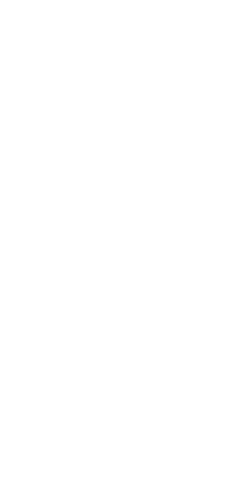

In [0]:
viz_model(gif=True)

**Описание работы модели**

Входной слой имеет только узлы. Дальнейшая его работа - взять данные и передать их на скрытый слой.

Плотный слой имеет связанные с ним звенья (ребра) с весами и всем прочим. Он также имеет функцию активации.

Данные от каждого входного узла умножаются на вес ссылок, через которые эти входные узлы связаны с первым скрытым слоем. Каждый узел скрытого слоя затем объединяет все входы в него (по одному от каждого входного узла) и проходит через активацию активации.

Подобный процесс повторяется для второго скрытого слоя.

Выпадающий слой (Dropout) добавляется перед выходным слоем. Он случайно отбрасывает определенный процент (в нашем случае 20%) ссылок, которые связаны с выходным узлом. Это хорошая практика и в целом помогает обуздать переобучение.

Мы просто определяем каждый слой и предыдущий слой, к которому он подключен, а затем упаковываем их все вместе, используя функцию (Model)

15 новых столбцов данных (df_new) будут передаваться через эту сеть по одной строке за раз. Сеть выдаст ответ, который будет сравниваться со значением в первом столбце. Это первое предсказание будет основано на весах, которые устанавливаются случайным образом. Ошибка в прогнозе будет использоваться для изменения весов таким образом, чтобы прогноз был лучше.

Это произойдет для всех 1034 строк. Мы можем отрегулировать веса после прохождения нескольких выборок (rows) в том, что мы называем «batch». Когда все строки прошли таким образом, мы говорим, что одна «эпоха» окончена.

Но сколько эпох мы должны пройти? Когда мы почувствуем, что наша модель нейронной сети захватила шаблоны данных и может делать прогнозы. Как мы это обеспечим?

Что мы делаем, это держим несколько образцов данных в качестве набора для проверки. Мы не используем их для обучения (т.е. для обновления весов). Мы запускаем проверочный набор только после каждой эпохи и проверяем ошибку. Мы также отслеживаем ошибку обучения, но она не так важна, как ошибка проверки, поскольку ошибка обучения - это то, что регулирует весовые коэффициенты. Таким образом, в некотором смысле обучающие данные - это то, в чем впитывается сеть.

Валидационные данные - это то, в чем они не впитываются. Поскольку мы продолжаем проверять ошибки, только когда ошибка валидации приближается к ошибке обучения, мы останавливаемся дальнейшее обучение.

Есть много способов вычислить ошибку. Здесь мы использовали «mean_squared_error», а также алгоритм оптимизатора «adam», который отвечает за обновление весов.

### Разделение данных и Масштабирование данных

#### Разделение данных

Мы выделим 5% выборок _(строк)_ случайным образом для последующих целей тестирования. Оставшиеся 95% снова делятся случайным образом. Примерно 5% из них используется в качестве набора для проверки, а остальные - в качестве учебного набора. Все это разделение происходит по строкам.

Также мы должны разбить по столбцам. Первый столбец - это наши фактические значения _(target)_. Они не передаются в нейронную сеть. Остальные 15 столбцов _(входные регрессоры)_ подаются.

Таким образом, разделение данных происходит как по строкам, так и по столбцам. Нарезанные фрагменты данных, имеющие только входные колонки регрессора, обычно имеют "X" в именах, которые мы им присваиваем, а нарезанные фрагменты данных _(или серии)_ , имеющие только действительные значения _(также называемые целевыми значениями, поскольку они являются "target" для нейронных сетей, чтобы точно предсказывать во время обучения)_ , имеют "y" в именах, которые мы им присваиваем.

Поскольку это данные временных рядов, разбиение набора данных случайным образом не является разумной мыслью. Поэтому, просто разделим их упорядоченно.

In [0]:
test_set_size = 0.05
valid_set_size= 0.05

df_copy = df_new.reset_index(drop=True)

df_test = df_copy.iloc[ int(np.floor(len(df_copy)*(1-test_set_size))) : ]
df_train_plus_valid = df_copy.iloc[ : int(np.floor(len(df_copy)*(1-test_set_size))) ]

df_train = df_train_plus_valid.iloc[ : int(np.floor(len(df_train_plus_valid)*(1-valid_set_size))) ]
df_valid = df_train_plus_valid.iloc[ int(np.floor(len(df_train_plus_valid)*(1-valid_set_size))) : ]


X_train, y_train = df_train.iloc[:, 1:], df_train.iloc[:, 0]
X_valid, y_valid = df_valid.iloc[:, 1:], df_valid.iloc[:, 0]
X_test, y_test = df_test.iloc[:, 1:], df_test.iloc[:, 0]

print('Shape of training inputs, training target:', X_train.shape, y_train.shape)
print('Shape of validation inputs, validation target:', X_valid.shape, y_valid.shape)
print('Shape of test inputs, test target:', X_test.shape, y_test.shape)

Shape of training inputs, training target: (932, 15) (932,)
Shape of validation inputs, validation target: (50, 15) (50,)
Shape of test inputs, test target: (52, 15) (52,)


#### Масштабирование данных

Мы нормализуем наши данные в диапазоне от 0,01 до 0,99 перед подачей их в нейронную сеть.

_Функция [MinMaxScaler()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) принимает в датафреймах или сериях (также может принимать в массивах), но всегда возвращает n-мерные массивы._

In [0]:
from sklearn.preprocessing import MinMaxScaler

Target_scaler = MinMaxScaler(feature_range=(0.01, 0.99))
Feature_scaler = MinMaxScaler(feature_range=(0.01, 0.99))

X_train_scaled = Feature_scaler.fit_transform(np.array(X_train))
X_valid_scaled = Feature_scaler.fit_transform(np.array(X_valid))
X_test_scaled = Feature_scaler.fit_transform(np.array(X_test))

y_train_scaled = Target_scaler.fit_transform(np.array(y_train).reshape(-1,1))
y_valid_scaled = Target_scaler.fit_transform(np.array(y_valid).reshape(-1,1))
y_test_scaled = Target_scaler.fit_transform(np.array(y_test).reshape(-1,1))

- Данные предобработанны
- Нейронная сеть готова к обучению

### Обучение и проверка модели

In [0]:
model.fit(
    x=X_train_scaled, 
    y=y_train_scaled, 
    batch_size=5, 
    epochs=30, 
    verbose=1, 
    validation_data=(X_valid_scaled, 
                     y_valid_scaled), 
    shuffle=True)

Train on 932 samples, validate on 50 samples
Epoch 1/30
932/932 [==============================] - 1s 2ms/sample - loss: 0.0155 - val_loss: 0.0390
Epoch 2/30
932/932 [==============================] - 1s 601us/sample - loss: 0.0039 - val_loss: 0.0389
Epoch 3/30
932/932 [==============================] - 1s 639us/sample - loss: 0.0034 - val_loss: 0.0472
Epoch 4/30
932/932 [==============================] - 0s 531us/sample - loss: 0.0026 - val_loss: 0.0399
Epoch 5/30
932/932 [==============================] - 1s 584us/sample - loss: 0.0023 - val_loss: 0.0403
Epoch 6/30
932/932 [==============================] - 1s 578us/sample - loss: 0.0023 - val_loss: 0.0234
Epoch 7/30
932/932 [==============================] - 1s 583us/sample - loss: 0.0020 - val_loss: 0.0549
Epoch 8/30
932/932 [==============================] - 1s 567us/sample - loss: 0.0017 - val_loss: 0.0228
Epoch 9/30
932/932 [==============================] - 1s 569us/sample - loss: 0.0019 - val_loss: 0.0262
Epoch 10/30
932/932 [

В случае, если потеря валидации _(validation loss)_ оставалась значительно больше, чем потеря тренировки _(training loss)_ в конце тренировки, но постоянно снижалась в последние несколько эпох, это было бы признаком того, что нам нужно запускать нашу модель для большего количества эпох, так как модель нуждалась в большем количестве тренировок.

Если бы потеря валидации _(validation loss)_ оставалась значительно больше, чем потеря тренировки _(training loss)_ в конце тренировки, а также становилась более или менее статичной, то это было бы признаком "переобучения", т.е. наша модель работает слишком хорошо на тренировочных данных, она прекрасно захватила ее, включая шум, но она бы плохо работала на данных которые не видела. В таком случае рекомендуется увеличить значение в слое выпадения _(dropout layer)_ , уменьшить количество _(Epoch)_ , увеличить размер партии _(batch size)_ , уменьшить количество скрытых слоев _(hidden layers)_ , уменьшить количество узлов в скрытых слоях _(hidden layers)_ .

**Наши потери при проверке не сильно изменились, особенно по сравнению с потерями при обучении. Мы можем приписать это небольшому количеству примеров обучения, которые у нас есть, в контексте модели, которую мы использовали.**

_LSTM и CNN могут давать лучшие результаты, чем обычные NN на одних и тех же данных._

## 4. Результаты

### Прогнозирование на тестовом наборе данных

In [0]:
y_pred = model.predict(X_test_scaled)

Помним, что все наши входы и цели были уменьшены в диапазоне (0, 1). Таким образом, прогнозы также лежат в этом диапазоне. Нам нужно уменьшить их в обратном направлении.

In [0]:
y_pred_rescaled = Target_scaler.inverse_transform(y_pred)

### Оценка качества модели на тестовой выборке

Одним из способов измерения точности нашей модели на тестовых данных, является сравнение погрешности ее прогнозов с истинными значениями. _Это может быть ошибка среднего квадрата, или средняя ошибка и т.д._

_([r2_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html) измеряет среднеквадратичное расстояние между истинными значениями и значениями лежащими в гиперплоскости предиктора (наши прогнозируемые значения), и выдает оценку от 0 до 1. Чем больше значение r2 ближе к единице, тем лучше прогнозы вашего модель)_

In [0]:
from sklearn.metrics import r2_score

y_test_rescaled =  Target_scaler.inverse_transform(y_test_scaled)
score = r2_score(y_test_rescaled, y_pred_rescaled)
print('R-squared score for the test set:', round(score,4))

R-squared score for the test set: 0.7222


### Построение графика прогноза



In [0]:
y_actual = pd.DataFrame(y_test_rescaled, columns=['Actual Close Price'])
y_hat = pd.DataFrame(y_pred_rescaled, columns=['Predicted Close Price'])

In [0]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        y=y_actual['Actual Close Price'], 
        line_color='#ee2c2c',
        name='Actual',
        mode='lines+markers'
        )
    )

fig.add_trace(
    go.Scatter(
        y=y_hat['Predicted Close Price'], 
        line_color='#1874cd',
        name='Predicted',
        mode='lines+markers'
        )
    )

fig.update_layout(
    title='Bitcoin Stock Closing Prices',
    xaxis_title='Test Set Day no.',
    yaxis_title='USD ($)',
    xaxis_rangeslider_visible=False,
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)

fig.show()

## 5. Заключение

### Выводы

- Задача прогноза временных рядов зависит от внутренних и внешних факторов во временном отрезке, что достаточно сильно приближает модели по временным рядам к категории моделей “черного ящика”.

- По прогнозу данного набора данных. **В горизонте прогнозирования на один день, прогноз выглядит правдоподобно** для задачи в которой присутствуют факторы времени и риска.

### Куда дальше?

- LSTM и CNN могут давать лучшие результаты, чем обычные NN на одних и тех же данных.

### Литература и полезные ссылки:
- [Анализ временных рядов с помощью Python](https://habr.com/ru/company/ods/blog/327242/)
- [Сравнение моделей временных рядов](https://basegroup.ru/community/bank/compare-model)
- [Holt-Winters Forecasting for Dummies (or Developers)](https://grisha.org/blog/2016/01/29/triple-exponential-smoothing-forecasting/)
- [Open Machine Learning Course. Topic 9. Part 1. Time series analysis in Python](https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-9-time-series-analysis-in-python-a270cb05e0b3)
- [Open Machine Learning Course. Topic 9. Part 2. Predicting the future with Facebook Prophet](https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-9-part-3-predicting-the-future-with-facebook-prophet-3f3af145cdc)
- [Notes on regression and time series analysis](https://people.duke.edu/~rnau/411home.htm)
- [The Time Series They Are a-Changing: Why all good models eventually fail](https://towardsdatascience.com/the-time-series-they-are-a-changing-why-all-good-models-eventually-fail-24a96a5f48d3)
- [Two key challenges for time series analysis](https://medium.com/wwblog/two-key-challenges-for-time-series-analysis-e18f6eaa098f)
- [Introduction to Interactive Time Series Visualizations with Plotly in Python](https://towardsdatascience.com/introduction-to-interactive-time-series-visualizations-with-plotly-in-python-d3219eb7a7af)
- [Being Bayesian and thinking deep: time-series prediction with uncertainty](https://medium.com/@dan_90739/being-bayesian-and-thinking-deep-time-series-prediction-with-uncertainty-25ff581b056c)
- [Facing the ARIMA Model against Neural Networks](https://towardsdatascience.com/facing-the-arima-model-against-neural-networks-745ba5a933ca)
- [Stationarity test for time series](https://medium.com/swlh/stochasticity-test-for-time-series-5312f1325700)
- [Time Series Decomposition and StatsModels Parameters](https://medium.com/@amitrani/time-series-decomposition-and-statsmodels-parameters-69e54d035453)
- [Получение котировок акций при помощи Python](https://habr.com/ru/post/487644/)
- [TensorFlow Time Series Forecasting](https://www.tensorflow.org/tutorials/structured_data/time_series)
- [Descriptive statistics in Time Series Modelling](https://towardsdatascience.com/descriptive-statistics-in-time-series-modelling-db6ec569c0b8)
- [Keras documentation](https://keras.io/)
- [Методы оптимизации нейронных сетей](https://habr.com/ru/post/318970/)
- [Функции активации нейросети](https://neurohive.io/ru/osnovy-data-science/activation-functions/)

In [0]:
pass